# 5. AutoEncoder

Install and import necessary libraries

In [1]:
!pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import category_encoders as ce

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

Loading of dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
csv_path_train = '/content/drive/My Drive/Colab Notebooks/BT4222/Project/train_dataset.csv'
csv_path_test = '/content/drive/My Drive/Colab Notebooks/BT4222/Project/test_dataset.csv'

df_train = pd.read_csv(csv_path_train)
df_test = pd.read_csv(csv_path_test)

# Display the DataFrame
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V296,V297,V301,V303,V305,V307,V309,V310,V314,V320
0,2987001.0,0,86401.0,29.0,W,2755.0,404.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2987002.0,0,86469.0,59.0,W,4663.0,490.0,150.0,visa,166.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2987003.0,0,86499.0,50.0,W,18132.0,567.0,150.0,mastercard,117.0,...,0.0,0.0,0.0,0.0,1.0,1758.0,0.0,354.0,0.0,0.0
3,2987004.0,0,86506.0,50.0,H,4497.0,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2987005.0,0,86510.0,49.0,W,5937.0,555.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V296,V297,V301,V303,V305,V307,V309,V310,V314,V320
0,3663549.0,18403224.0,31.95,W,10409.0,111.0,150.0,visa,226.0,debit,...,0.0,0.0,0.0,0.0,1.0,47.95,0.00,47.95,0.00,0.0
1,3663550.0,18403264.0,49.00,W,4272.0,111.0,150.0,visa,226.0,debit,...,0.0,0.0,0.0,0.0,1.0,280.00,0.00,280.00,0.00,0.0
2,3663551.0,18403310.0,171.00,W,4476.0,574.0,150.0,visa,226.0,debit,...,2.0,0.0,0.0,0.0,1.0,1321.00,0.00,1058.00,0.00,263.0
3,3663552.0,18403310.0,284.95,W,10989.0,360.0,150.0,visa,166.0,debit,...,0.0,0.0,0.0,0.0,1.0,0.00,0.00,0.00,282.54,0.0
4,3663553.0,18403316.0,67.95,W,18018.0,452.0,150.0,mastercard,117.0,debit,...,0.0,0.0,0.0,0.0,1.0,183.85,67.95,183.85,183.85,0.0


Encoding of categorical variables

In [6]:
object_columns = df_train.select_dtypes(include = ['object'])
object_columns

,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,mastercard,credit,gmail.com,T,T,T,M0,T,T,F,F,T
1,W,visa,debit,outlook.com,T,T,T,M0,F,F,F,F,F
2,W,mastercard,debit,yahoo.com,T,T,T,M0,T,F,F,F,T
3,H,mastercard,credit,gmail.com,T,T,T,M0,F,T,F,F,T
4,W,visa,debit,gmail.com,T,T,T,M1,F,T,F,F,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...
578076,C,mastercard,debit,gmail.com,T,T,T,M2,T,F,F,F,T
578077,W,mastercard,debit,gmail.com,T,F,F,M0,F,T,F,F,F
578078,W,mastercard,debit,gmail.com,T,F,F,M0,T,T,F,F,T
578079,W,mastercard,debit,aol.com,T,T,T,M0,F,T,F,F,T


Label encoding is used for column _M4_ as it is ordinal. Binary Encoding is used for columns _M1-9_. One Hot encoding is used for columns _ProductCD,card4,card6_

In [7]:
# Label encoding: M4
label_encoder = LabelEncoder()
df_train['M4_Encoded'] = label_encoder.fit_transform(df_train['M4'])
df_test['M4_Encoded'] = label_encoder.fit_transform(df_test['M4'])

#Binary Encoding
df_train['M1_encoded'] = label_encoder.fit_transform(df_train['M1'])
df_test['M1_encoded'] = label_encoder.fit_transform(df_test['M1'])

df_train['M2_encoded'] = label_encoder.fit_transform(df_train['M2'])
df_test['M2_encoded'] = label_encoder.fit_transform(df_test['M2'])

df_train['M3_encoded'] = label_encoder.fit_transform(df_train['M3'])
df_test['M3_encoded'] = label_encoder.fit_transform(df_test['M3'])

df_train['M4_encoded'] = label_encoder.fit_transform(df_train['M4'])
df_test['M4_encoded'] = label_encoder.fit_transform(df_test['M4'])

df_train['M5_encoded'] = label_encoder.fit_transform(df_train['M5'])
df_test['M5_encoded'] = label_encoder.fit_transform(df_test['M5'])

df_train['M6_encoded'] = label_encoder.fit_transform(df_train['M6'])
df_test['M6_encoded'] = label_encoder.fit_transform(df_test['M6'])

df_train['M7_encoded'] = label_encoder.fit_transform(df_train['M7'])
df_test['M7_encoded'] = label_encoder.fit_transform(df_test['M7'])

df_train['M8_encoded'] = label_encoder.fit_transform(df_train['M8'])
df_test['M8_encoded'] = label_encoder.fit_transform(df_test['M8'])

df_train['M9_encoded'] = label_encoder.fit_transform(df_train['M9'])
df_test['M9_encoded'] = label_encoder.fit_transform(df_test['M9'])

In [8]:
print(set(df_train.columns)-set(df_test.columns))

{'isFraud'}


In [9]:
# One Hot Encoding
df_encoded = pd.get_dummies(df_train, columns = ['ProductCD','card4','card6'])
df_encoded_test = pd.get_dummies(df_test, columns = ['ProductCD','card4','card6'])
df_encoded_test['card6_debit or credit'] = 0

In [10]:
print(set(df_encoded.columns)-set(df_encoded_test.columns))

{'isFraud'}


In [11]:
df_encoded.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit
0,2987001.0,0,86401.0,29.0,2755.0,404.0,150.0,102.0,325.0,87.0,...,0,1,0,0,1,0,0,1,0,0
1,2987002.0,0,86469.0,59.0,4663.0,490.0,150.0,166.0,330.0,87.0,...,0,1,0,0,0,1,0,0,1,0
2,2987003.0,0,86499.0,50.0,18132.0,567.0,150.0,117.0,476.0,87.0,...,0,1,0,0,1,0,0,0,1,0
3,2987004.0,0,86506.0,50.0,4497.0,514.0,150.0,102.0,420.0,87.0,...,0,0,0,0,1,0,0,1,0,0
4,2987005.0,0,86510.0,49.0,5937.0,555.0,150.0,226.0,272.0,87.0,...,0,1,0,0,0,1,0,0,1,0


In [12]:
# Drop categorical columns
df_encoded = df_encoded.drop(columns = ['P_emaildomain','M1','M2','M3','M4','M5','M6','M7','M8','M9'])
df_encoded_test = df_encoded_test.drop(columns = ['P_emaildomain','M1','M2','M3','M4','M5','M6','M7','M8','M9'])

number_columns = df_train.select_dtypes(include = ['int64','float64']).columns
for col in number_columns[3:]:
    df_encoded[col] = StandardScaler().fit_transform(df_encoded[col].values.reshape(-1, 1))
    df_encoded_test[col] = StandardScaler().fit_transform(df_encoded_test[col].values.reshape(-1, 1))

In [13]:
df_encoded_not_fraud = df_encoded[df_encoded['isFraud'] == 0]
df_encoded_not_fraud = df_encoded_not_fraud.drop(columns = ['TransactionID','isFraud','TransactionDT'])
df_encoded_test = df_encoded_test.drop(columns = ['TransactionID','TransactionDT'])

df_encoded_not_fraud = df_encoded_not_fraud.values
df_encoded_test = df_encoded_test.values
df_encoded_not_fraud

array([[-0.44313563, -1.46273526,  0.26303099, ...,  1.        ,
         0.        ,  0.        ],
       [-0.31674531, -1.07328995,  0.80774023, ...,  0.        ,
         1.        ,  0.        ],
       [-0.3546624 ,  1.67589187,  1.29544502, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.43492026,  0.43183045,  1.47279222, ...,  0.        ,
         1.        ,  0.        ],
       [-0.07239068, -0.42768433,  0.75073578, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.61411941,  1.05008509, -1.21908487, ...,  1.        ,
         0.        ,  0.        ]])

In [14]:
df_encoded_test

array([[-0.41720416,  0.09179672, -1.59278008, ...,  0.        ,
         1.        ,  0.        ],
       [-0.34812603, -1.16392264, -1.59278008, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.14615733, -1.12218128,  1.32645218, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.34812603,  1.37104675,  0.79682905, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.27175392,  1.36286217,  0.96076002, ...,  0.        ,
         1.        ,  0.        ],
       [-0.44801179, -0.86907311, -1.23339295, ...,  1.        ,
         0.        ,  0.        ]])

## AutoEncoder Training

In [15]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(121, 64),
            nn.Tanh(),
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(16, 64),
           nn.Tanh(),
           nn.Linear(64, 121),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [16]:
model = Autoencoder().double().cpu()

In [17]:
# Hyperparameters for training such as number of epochs, minibatch size and learning rate are defined
num_epochs = 50
minibatch_size = 64
learning_rate = 1e-2

train_loader = data_utils.DataLoader(df_encoded_not_fraud, batch_size=minibatch_size, shuffle=True)
# test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)
history = {}
history['train_loss'] = []
history['test_loss'] = []

for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)

epoch [1/50], loss:0.4225
epoch [2/50], loss:0.4095
epoch [3/50], loss:0.4075
epoch [4/50], loss:0.4051
epoch [5/50], loss:0.4138
epoch [6/50], loss:0.4143
epoch [7/50], loss:0.4163
epoch [8/50], loss:0.4130
epoch [9/50], loss:0.4114
epoch [10/50], loss:0.4140
epoch [11/50], loss:0.4041
epoch [12/50], loss:0.4143
epoch [13/50], loss:0.4110
epoch [14/50], loss:0.4134
epoch [15/50], loss:0.4084
epoch [16/50], loss:0.4096
epoch [17/50], loss:0.4080
epoch [18/50], loss:0.4099
epoch [19/50], loss:0.4102
epoch [20/50], loss:0.4130
epoch [21/50], loss:0.4111
epoch [22/50], loss:0.4121
epoch [23/50], loss:0.4098
epoch [24/50], loss:0.4106
epoch [25/50], loss:0.4142
epoch [26/50], loss:0.4128
epoch [27/50], loss:0.4071
epoch [28/50], loss:0.4057
epoch [29/50], loss:0.4130
epoch [30/50], loss:0.4150
epoch [31/50], loss:0.4103
epoch [32/50], loss:0.4121
epoch [33/50], loss:0.4091
epoch [34/50], loss:0.4076
epoch [35/50], loss:0.4063
epoch [36/50], loss:0.4175
epoch [37/50], loss:0.4129
epoch [38/

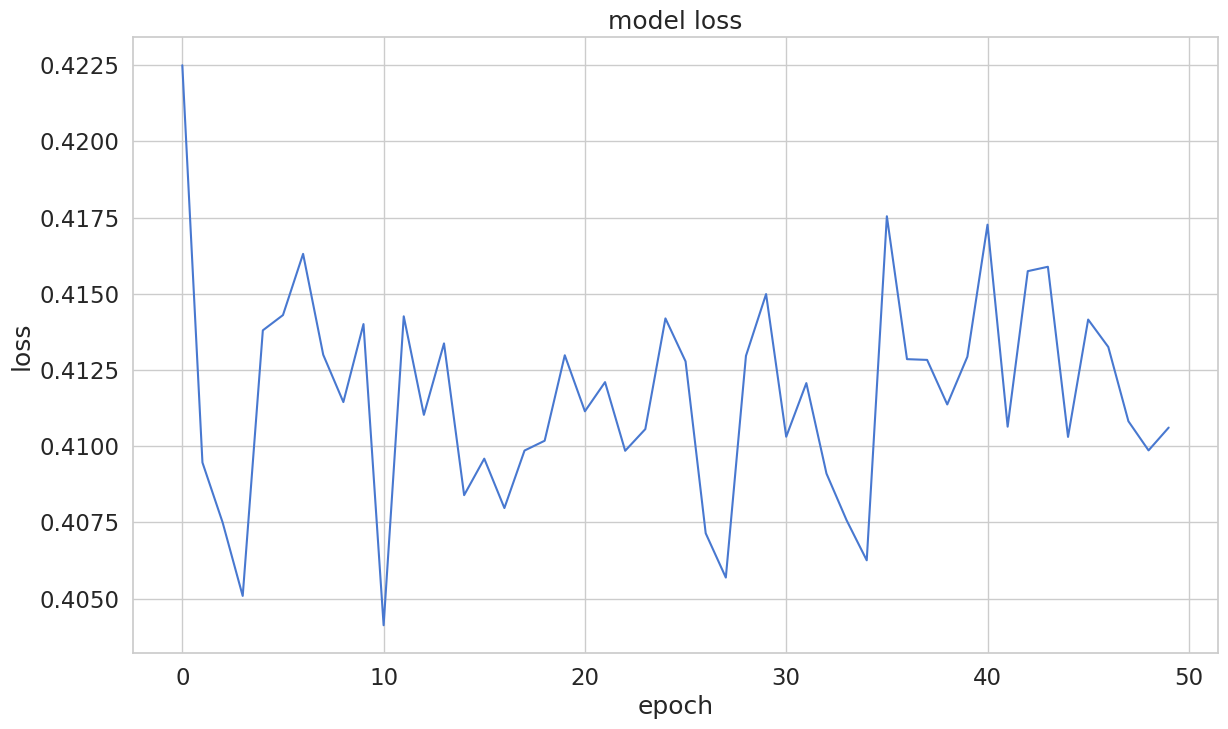

In [18]:
# The training loss history is plotted over epochs
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

## Lowering the learning rate

In [19]:
# Hyperparameters for training such as number of epochs, minibatch size and learning rate are defined
num_epochs = 50
minibatch_size = 64
learning_rate = 1e-3

train_loader = data_utils.DataLoader(df_encoded_not_fraud, batch_size=minibatch_size, shuffle=True)
# test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)
history = {}
history['train_loss'] = []
history['test_loss'] = []

# Training
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)

epoch [1/50], loss:0.3444
epoch [2/50], loss:0.3245
epoch [3/50], loss:0.3200
epoch [4/50], loss:0.3164
epoch [5/50], loss:0.3146
epoch [6/50], loss:0.3138
epoch [7/50], loss:0.3127
epoch [8/50], loss:0.3111
epoch [9/50], loss:0.3100
epoch [10/50], loss:0.3098
epoch [11/50], loss:0.3097
epoch [12/50], loss:0.3092
epoch [13/50], loss:0.3086
epoch [14/50], loss:0.3088
epoch [15/50], loss:0.3084
epoch [16/50], loss:0.3084
epoch [17/50], loss:0.3086
epoch [18/50], loss:0.3084
epoch [19/50], loss:0.3087
epoch [20/50], loss:0.3081
epoch [21/50], loss:0.3082
epoch [22/50], loss:0.3078
epoch [23/50], loss:0.3081
epoch [24/50], loss:0.3080
epoch [25/50], loss:0.3078
epoch [26/50], loss:0.3075
epoch [27/50], loss:0.3080
epoch [28/50], loss:0.3074
epoch [29/50], loss:0.3074
epoch [30/50], loss:0.3078
epoch [31/50], loss:0.3075
epoch [32/50], loss:0.3072
epoch [33/50], loss:0.3073
epoch [34/50], loss:0.3072
epoch [35/50], loss:0.3072
epoch [36/50], loss:0.3073
epoch [37/50], loss:0.3073
epoch [38/

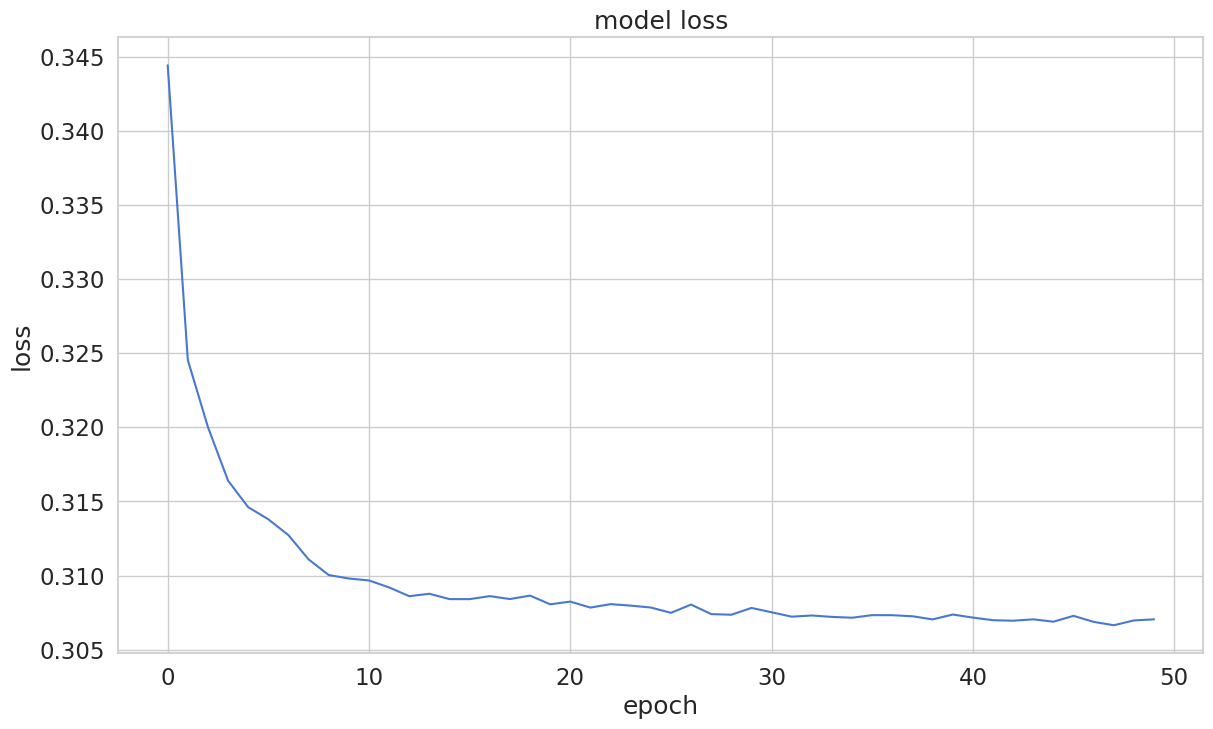

In [20]:
# The training loss history is plotted over epochs
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

## Obtaining the best model and testing

In [22]:
# Hyperparameters for training such as number of epochs, minibatch size and learning rate are defined
num_epochs = 50
minibatch_size = 64
learning_rate = 1e-3
lowest_loss = 0.3080
best_model = None

train_loader = data_utils.DataLoader(df_encoded_not_fraud, batch_size=minibatch_size, shuffle=True)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)
history = {}
history['train_loss'] = []
history['test_loss'] = []

# Training
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)
    if lowest_loss > mean_loss:
        best_model = model
        lowest_loss = mean_loss
        print("Model Saved")

epoch [1/50], loss:0.3065
Model Saved
epoch [2/50], loss:0.3063
Model Saved
epoch [3/50], loss:0.3064
epoch [4/50], loss:0.3066
epoch [5/50], loss:0.3063
Model Saved
epoch [6/50], loss:0.3061
Model Saved
epoch [7/50], loss:0.3064
epoch [8/50], loss:0.3070
epoch [9/50], loss:0.3065
epoch [10/50], loss:0.3068
epoch [11/50], loss:0.3065
epoch [12/50], loss:0.3062
epoch [13/50], loss:0.3060
Model Saved
epoch [14/50], loss:0.3063
epoch [15/50], loss:0.3061
epoch [16/50], loss:0.3063
epoch [17/50], loss:0.3061
epoch [18/50], loss:0.3062
epoch [19/50], loss:0.3065
epoch [20/50], loss:0.3061
epoch [21/50], loss:0.3063
epoch [22/50], loss:0.3060
epoch [23/50], loss:0.3061
epoch [24/50], loss:0.3065
epoch [25/50], loss:0.3064
epoch [26/50], loss:0.3064
epoch [27/50], loss:0.3058
Model Saved
epoch [28/50], loss:0.3068
epoch [29/50], loss:0.3064
epoch [30/50], loss:0.3067
epoch [31/50], loss:0.3063
epoch [32/50], loss:0.3062
epoch [33/50], loss:0.3064
epoch [34/50], loss:0.3067
epoch [35/50], loss

In [23]:
test_loader = data_utils.DataLoader(df_encoded_test, batch_size=1, shuffle=False)

pred_losses = {'pred_loss' : []}
best_model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = best_model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])

In [24]:
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF

,pred_loss
0,0.719518
1,0.333182
2,0.383781
3,0.113684
4,0.116863
...,...
487984,0.944785
487985,0.141548
487986,0.083423
487987,0.207679


In [25]:
reconstructionErrorDF.describe()

,pred_loss
count,487989.000000
mean,0.417685
std,10.567040
min,0.031172
25%,0.111361
50%,0.154156
75%,0.249609
max,4083.837914


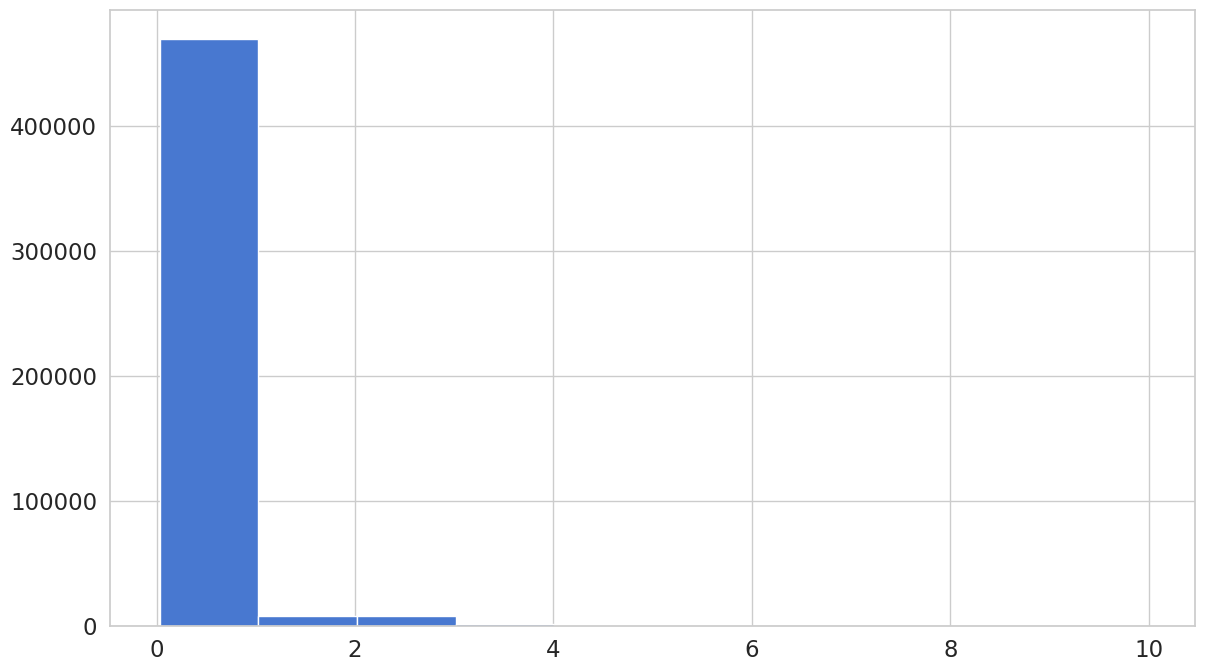

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[reconstructionErrorDF['pred_loss'] < 10]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)